In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [3]:
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 8))

In [4]:
# Đọc dữ liệu
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')  


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/insurance/insurance.csv'

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [ ]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


**Nhận xét:** Bộ dữ liệu này rất sạch, không có giá trị thiếu.

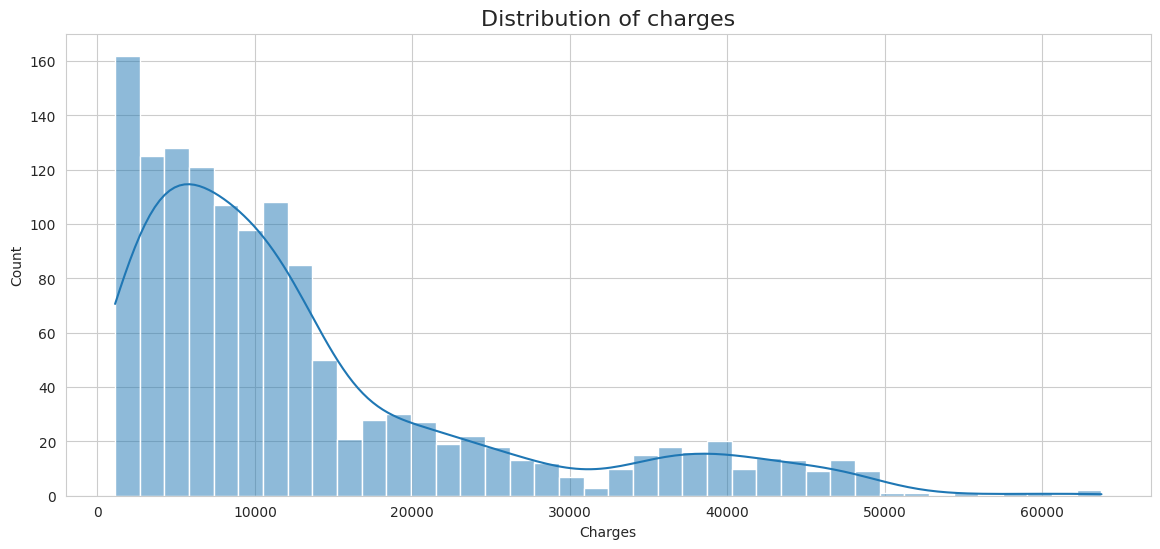

In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(df['charges'], kde=True, bins=40)
plt.title('Distribution of charges', fontsize=16)
plt.xlabel('Charges')
plt.ylabel('Count')
plt.show()

**Nhận xét:**
 - Phân bổ của `charges` bị **lệch phải (right-skewed)** rất rõ. Phần lớn `charges` tập trung ở mức thấp, nhưng có một số trường hợp với `charges` rất cao.
 - Cần áp dụng một phép biến đổi (VD: log transform) lên biến này.


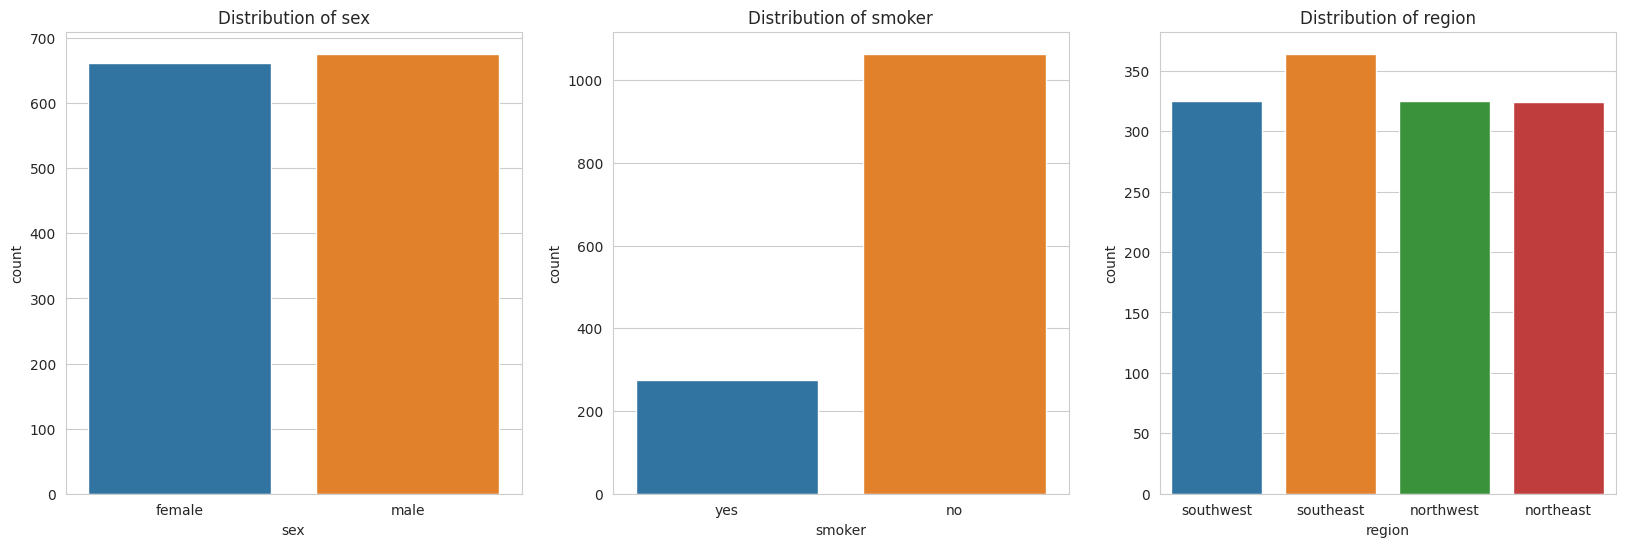

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.countplot(ax=axes[0], x='sex', data=df)
axes[0].set_title('Distribution of sex')

sns.countplot(ax=axes[1], x='smoker', data=df)
axes[1].set_title('Distribution of smoker')

sns.countplot(ax=axes[2], x='region', data=df)
axes[2].set_title('Distribution of region')
plt.show()


**Nhận xét:**
- Tỷ lệ nam/nữ khá cân bằng.
- Đa số mọi người không hút thuốc.
- Các khu vực cũng có số lượng người khá tương đồng.

#### 2.4. Phân tích mối quan hệ giữa các biến

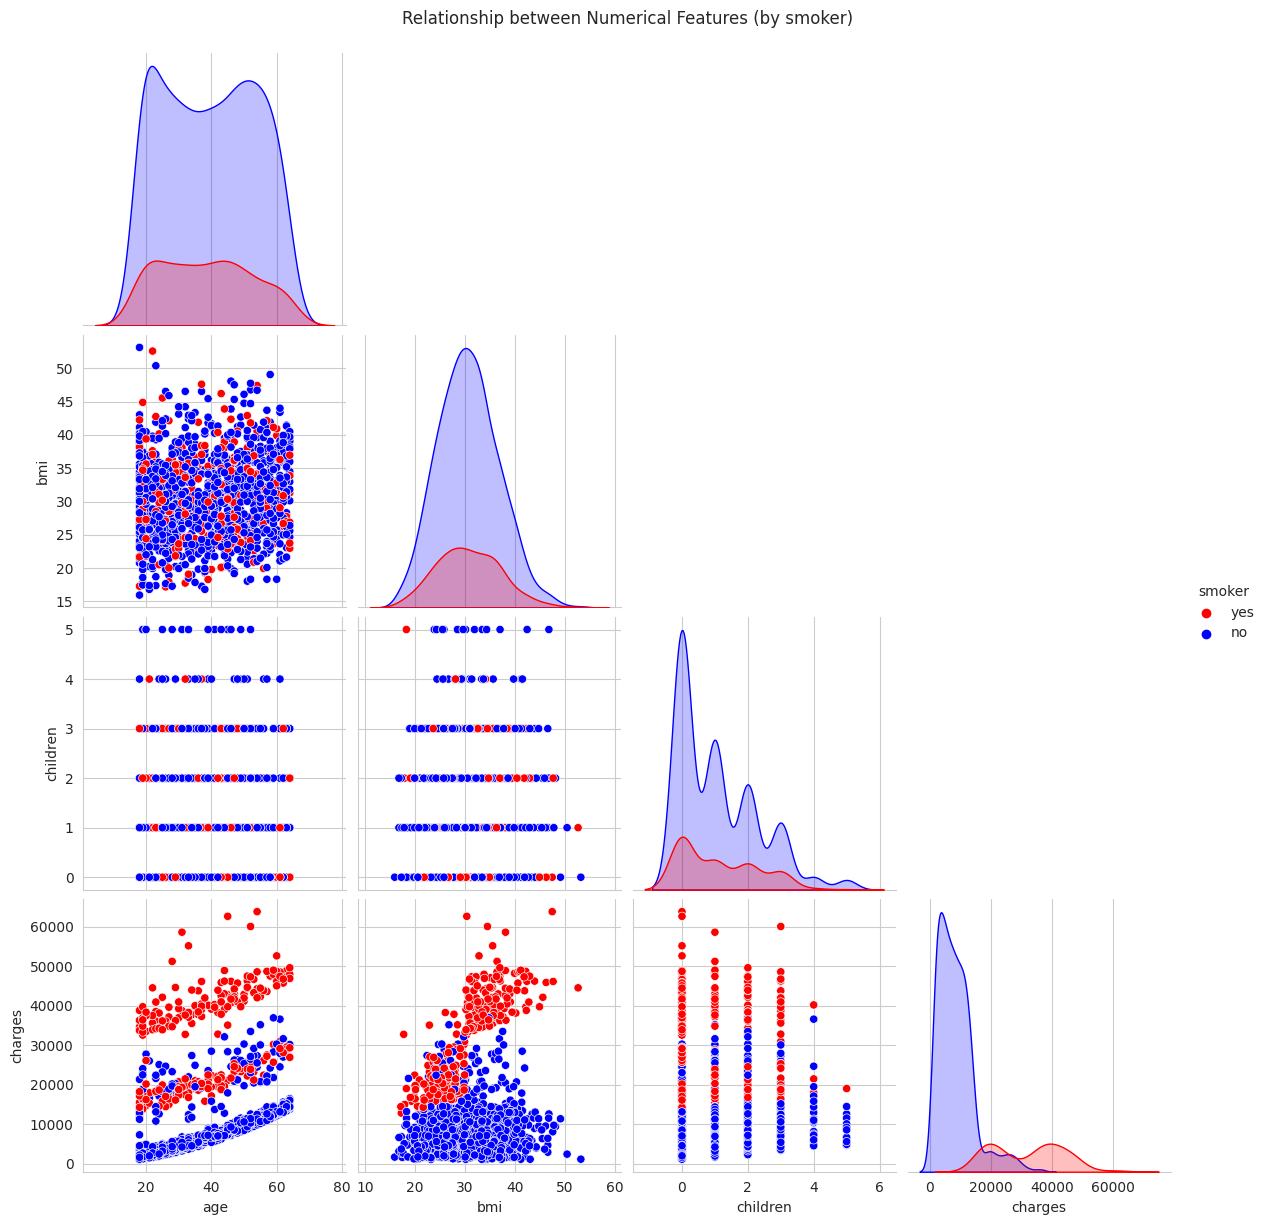

In [ ]:

sns.pairplot(df, hue='smoker', palette={'yes': 'red', 'no': 'blue'}, corner=True, height=3)
plt.suptitle('Relationship between Numerical Features (by smoker)', y=1.02) 
plt.show()

**Nhận xét quan trọng từ pairplot:**
 - **`age` vs `charges`:** Có một xu hướng rõ ràng là `charges` tăng theo tuổi. Có 3 dải `charges`í khác nhau, có thể liên quan đến các yếu tố khác.
 - **`bmi` vs `charges`:** Mối quan hệ này rất thú vị. Với những người không hút thuốc (màu xanh), BMI tăng chỉ làm `charges` tăng nhẹ. Tuy nhiên, với những người hút thuốc (màu đỏ), khi BMI tăng, `charges` tăng vọt.
 - **`smoker` là yếu tố quan trọng:** Nhóm hút thuốc có `charges`cao hơn hẳn và có mối tương quan mạnh hơn với `age` và `bmi`.

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', style='smoker', s=100, palette={'yes': 'orangered', 'no': 'dodgerblue'})
plt.title('Bmi vs charges(by_smoker)', fontsize=16)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()


NameError: name 'plt' is not defined

**Kết luận EDA:**
 1.  `smoker` là biến có ảnh hưởng mạnh nhất đến `charges`.
 2.  `age` và `bmi` cũng có tương quan dương với `charges`, và ảnh hưởng của chúng còn mạnh hơn đối với nhóm hút thuốc.
 3.  Biến mục tiêu `charges` bị lệch, cần được xử lý để cải thiện hiệu năng mô hình.

In [ ]:
df_processed = df.copy()

**Xử lý biến lệch (charges):** Áp dụng log transform để đưa phân phối về gần dạng chuẩn hơn.
Dùng `np.log1p` (tương đương log(1+x)) để tránh lỗi khi x=

In [ ]:
df_processed['charges'] = np.log1p(df_processed['charges'])

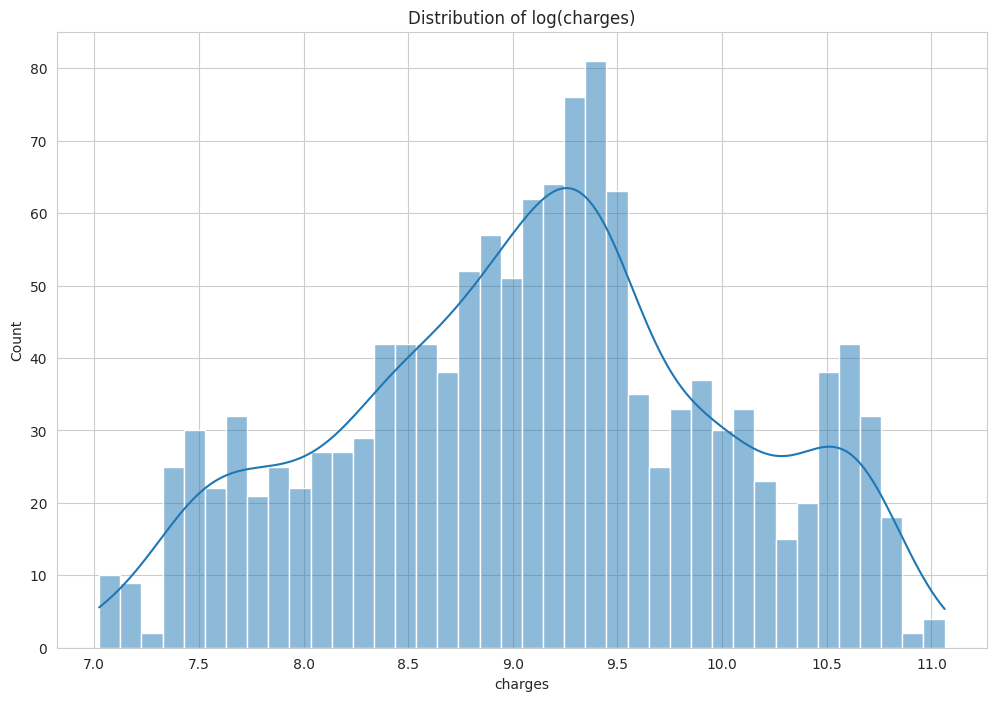

In [ ]:
sns.histplot(df_processed['charges'], kde=True, bins=40)
plt.title('Distribution of log(charges)') 
plt.show()

In [ ]:
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập validation: {X_val.shape}")

Kích thước tập train: (1070, 6)
Kích thước tập validation: (268, 6)


In [ ]:
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']


### 3. Baseline Model: Linear Regression

 **Pipeline xử lý:**
 - **StandardScaler:** Chuẩn hóa các biến số (đưa về cùng một thang đo).
 - **OneHotEncoder:** Chuyển đổi các biến phân loại thành các cột nhị phân (0/1).

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Giữ lại các cột không được xử lý (nếu có)
)

 **Xây dựng Pipeline hoàn chỉnh cho mô hình**
 
 Pipeline giúp gộp các bước xử lý và mô hình thành một khối duy nhất,
 tránh rò rỉ dữ liệu và dễ dàng tái sử dụng.

In [ ]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

**Train mô hình**

In [ ]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', LinearRegression())])

 **Đánh giá mô hình**

In [ ]:
y_pred_log = lr_pipeline.predict(X_val)

Chuyển đổi kết quả dự đoán về thang đo ban đầu

In [ ]:
y_pred = np.expm1(y_pred_log)
y_val_orig = np.expm1(y_val) # Cũng chuyển đổi y_val để so sánh

In [ ]:
# Tính toán các chỉ số
r2_lr= r2_score(y_val_orig, y_pred)
mae_lr = mean_absolute_error(y_val_orig, y_pred)
print(f"R² Score: {r2_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:,.2f}")

R² Score: 0.6067
Mean Absolute Error (MAE): 3,888.44


**Phân tích kết quả Baseline:**
- **R² = 0.6067:** Mô hình giải thích được khoảng 60.7% sự biến thiên của chi phí y tế. Đây là một kết quả khá tốt cho mô hình cơ bản.
- **MAE ≈ 3,888:** Trung bình, dự đoán của mô hình sai lệch khoảng $3888 so với giá trị thực.

### 4. Improved Model: XGBoost with Feature Engineering

In [ ]:
X_train_fe = X_train.copy()
X_val_fe = X_val.copy()

**Feature Engineering**

Tạo biến `bmi_obese` cho biết một người có bị béo phì hay không (BMI >= 30)

In [ ]:
X_train_fe['bmi_obese'] = (X_train_fe['bmi'] >= 30).astype(int)
X_val_fe['bmi_obese'] = (X_val_fe['bmi'] >= 30).astype(int)

Tạo biến tương tác giữa tuổi và tình trạng hút thuốc

In [ ]:

smoker_map = {'yes': 1, 'no': 0} #mã hóa 'smoker' thành số
X_train_fe['smoker_encoded'] = X_train_fe['smoker'].map(smoker_map)
X_val_fe['smoker_encoded'] = X_val_fe['smoker'].map(smoker_map)

X_train_fe['age_smoker'] = X_train_fe['age'] * X_train_fe['smoker_encoded']
X_val_fe['age_smoker'] = X_val_fe['age'] * X_val_fe['smoker_encoded']


In [ ]:
# Cập nhật lại danh sách các biến
numerical_features_fe = ['age', 'bmi', 'children', 'bmi_obese', 'age_smoker']
# 'smoker_encoded' không cần đưa vào vì đã được dùng để tạo biến tương tác
# và 'smoker' vẫn sẽ được OneHotEncode.

**Xây dựng Pipeline mới cho XGBoost**

In [ ]:
preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_fe),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_fe),
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42))
])


**Train mô hình XGBoost**

In [ ]:
xgb_pipeline.fit(X_train_fe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'bmi_obese', 'age_smoker']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=N...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=150, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

**Đánh giá mô hình XGBoost**

In [ ]:
y_pred_log_xgb = xgb_pipeline.predict(X_val_fe)

Chuyển đổi về thang đo ban đầu

In [ ]:
y_pred_xgb = np.expm1(y_pred_log_xgb)

In [ ]:
r2_xgb = r2_score(y_val_orig, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val_orig, y_pred_xgb)
print(f"R²: {r2_xgb:.4f}")
print(f"Mean Absolute Error: ${mae_xgb:,.2f}")

R²: 0.8622
Mean Absolute Error: $2,171.02


### 5. Model Comparison & Conclusion

In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'R² Score': [r2_lr, r2_xgb],
    'MAE': [mae_lr, mae_xgb]
})
print(results)

               Model  R² Score          MAE
0  Linear Regression  0.606698  3888.443159
1            XGBoost  0.862228  2171.023946


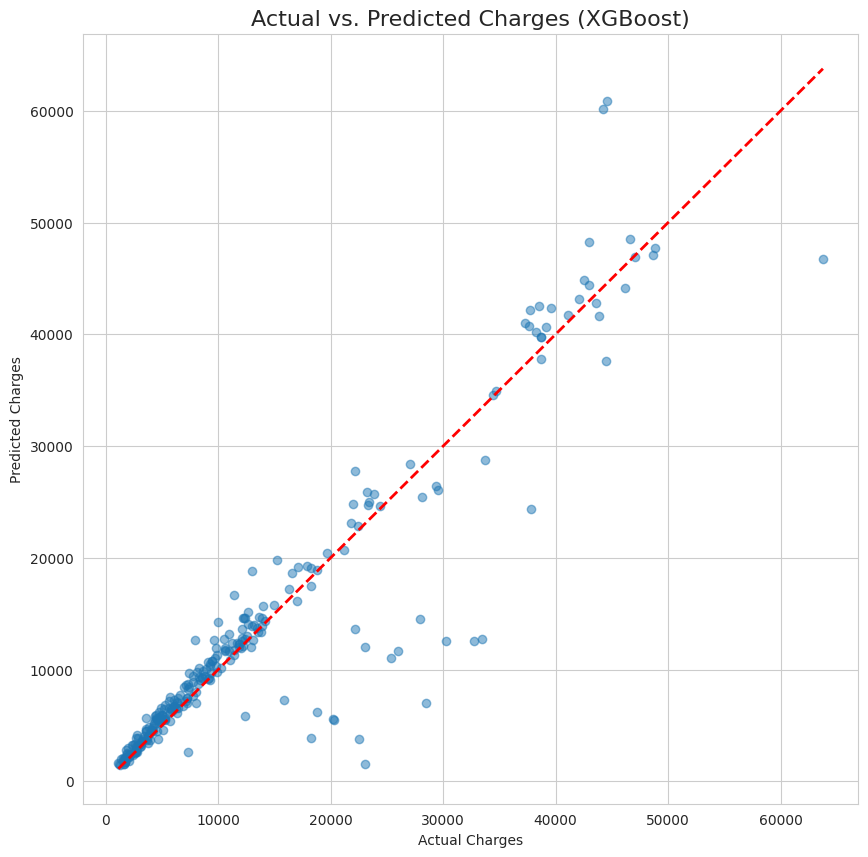

In [ ]:

plt.figure(figsize=(10, 10))
plt.scatter(y_val_orig, y_pred_xgb, alpha=0.5)
plt.plot([min(y_val_orig), max(y_val_orig)], [min(y_val_orig), max(y_val_orig)], color='red', linestyle='--', lw=2)
plt.title('Actual vs. Predicted Charges (XGBoost)', fontsize=16) 
plt.xlabel('Actual Charges') 
plt.ylabel('Predicted Charges') 
plt.show()


### 6. Save the Final Pipeline

In [ ]:
final_pipeline = xgb_pipeline.fit(X_train_fe, y_train)
joblib.dump(final_pipeline, 'medical_cost_prediction_pipeline.joblib')

['medical_cost_prediction_pipeline.joblib']